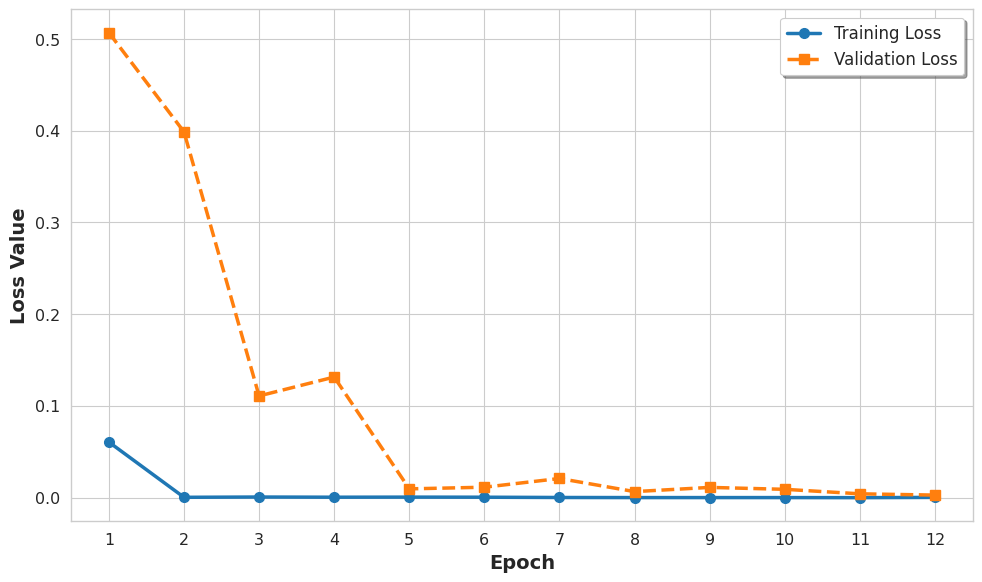

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. Chuẩn bị dữ liệu từ log của bạn ---
epochs = np.arange(1, 13)
train_loss = [0.0606, 0.0004, 0.0007, 0.0005, 0.0006, 0.0005,
              0.0002, 0.0001, 0.0001, 0.0001, 0.0000, 0.0003]
val_loss = [0.5069, 0.3988, 0.1109, 0.1315, 0.0096, 0.0114,
            0.0209, 0.0066, 0.0112, 0.0091, 0.0042, 0.0028]

# --- 2. Thiết lập cấu hình biểu đồ cho Paper ---
sns.set_theme(style="whitegrid", context="paper", font_scale=1.3)
fig, ax = plt.subplots(figsize=(10, 6))

# --- 3. Vẽ các đường dữ liệu ---
# Training Loss: Màu xanh dương, nét liền, điểm tròn
ax.plot(epochs, train_loss,
        label='Training Loss', color='#1f77b4',
        linestyle='-', linewidth=2.5, marker='o', markersize=7)

# Validation Loss: Màu cam, nét đứt, điểm vuông
ax.plot(epochs, val_loss,
        label='Validation Loss', color='#ff7f0e',
        linestyle='--', linewidth=2.5, marker='s', markersize=7)

# --- 4. Tinh chỉnh các trục và nhãn ---
ax.set_xlabel('Epoch', fontsize=14, fontweight='bold')
ax.set_ylabel('Loss Value', fontsize=14, fontweight='bold')
# ax.set_title('Training and Validation Loss over 12 Epochs', fontsize=16, pad=20)

# Đảm bảo trục X hiển thị đủ 12 số nguyên
ax.set_xticks(epochs)
ax.set_xlim([0.5, 12.5])

# Tùy chọn: Nếu giá trị Loss ở những epoch cuối quá nhỏ khó nhìn,
# bạn có thể mở comment dòng dưới để dùng thang đo Logarithm
# ax.set_yscale('log')

# Thêm chú thích (Legend)
ax.legend(loc='upper right', frameon=True, shadow=True, fontsize=12)

# Tự động căn chỉnh để không mất lề
plt.tight_layout()

# --- 5. Lưu file chất lượng cao ---
# Định dạng PDF (vector) cực kỳ quan trọng cho Paper vì không bao giờ bị vỡ nét
plt.savefig('loss_plot_12_epochs.pdf', format='pdf', bbox_inches='tight')
plt.savefig('loss_plot_12_epochs.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# ==========================================
# CONFIGURATION: IS_COLAB
# ==========================================
#
# **IMPORTANT: Auto-detects Colab, or you can override manually**
#
# - Auto-detection: Checks if 'google.colab' module exists
# - Override: Set IS_COLAB = True (Colab) or IS_COLAB = False (local)
#
# This controls:
# - Google Drive mounting (Colab only)
# - Working directory (Drive vs local)
# - Number of DataLoader workers (0 for Colab/Windows, 4 for Linux/Mac)
#

# Auto-detect Colab environment
try:
    import google.colab
    IS_COLAB = True
    print("[AUTO-DETECT] Running on Google Colab")
except ImportError:
    IS_COLAB = False
    print("[AUTO-DETECT] Running on local machine")

# OPTIONAL: Uncomment to manually override auto-detection
# IS_COLAB = True   # Force Colab mode
# IS_COLAB = False  # Force local mode

# ==========================================
# CONNECT TO GOOGLE DRIVE (COLAB)
# ==========================================
if IS_COLAB:
    try:
        import os
        from google.colab import drive

        drive.mount('/content/drive')
        # Thư mục làm việc trên Drive (tùy chỉnh theo ý bạn)
        DATA_ROOT = '/content/drive/MyDrive/botnet'
        os.makedirs(DATA_ROOT, exist_ok=True)
        os.chdir(DATA_ROOT)
        print(f"[COLAB MODE] Đã mount Drive. Thư mục làm việc: {os.getcwd()}")
    except Exception as e:
        print(f"[WARNING] Lỗi khi mount Drive: {e}")
        DATA_ROOT = '.'
else:
    import os
    # Local mode: Use current directory
    DATA_ROOT = '.'
    print(f"[LOCAL MODE] Thư mục làm việc: {os.path.abspath(DATA_ROOT)}")

[AUTO-DETECT] Running on Google Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[COLAB MODE] Đã mount Drive. Thư mục làm việc: /content/drive/MyDrive/botnet


In [ ]:
# # Install requirements
# !pip install torchinfo>=1.8.0 numpy>=1.24.0 pandas>=2.0.0 scikit-learn>=1.4.0,<1.5.0 imbalanced-learn>=0.12.0 torch torchvision matplotlib>=3.7.0 seaborn>=0.12.0 tqdm>=4.65.0 psutil>=5.9.0

In [ ]:
# =============================
# GLOBAL IMPORTS
# =============================
import os
import gc
import ssl
import argparse
import pickle
import urllib.request
from collections import Counter

import numpy as np
import pandas as pd
import psutil

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.utils import class_weight
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
from imblearn.over_sampling import SMOTE

try:
    from torchinfo import summary
except ImportError:
    summary = None

# Bypass SSL verification for dataset downloads
ssl._create_default_https_context = ssl._create_unverified_context



In [ ]:
# ==========================================
# CONTENT FROM: config.py
# ==========================================
import os
import sys
import torch

# =============================================================================
# SET WORKING DIRECTORY
# =============================================================================
if 'WORKING_DIR' not in globals():
    WORKING_DIR = '.'
    if IS_COLAB:
        WORKING_DIR = '/content/drive/MyDrive/botnet'

os.makedirs(WORKING_DIR, exist_ok=True)
# =============================================================================
# SYSTEM RESOURCES & DEVICE
# =============================================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# =============================================================================
# CONFIGURATION
# =============================================================================
# OPTIMIZED: Increase batch size to utilize 10GB spare GPU memory
BATCH_SIZE = 512  # Increased from 256 to 512 for better GPU utilization

# DataLoader Workers: Auto-detect based on platform and environment
# - Colab: 0 (multiprocessing issues)
# - Windows: 0 (multiprocessing issues with CUDA)
# - Linux/Mac: 4 (safe to use multiprocessing)
try:
    if IS_COLAB:
        N_WORKERS = 0
        print("[CONFIG] Colab detected: N_WORKERS = 0")
    elif sys.platform == 'win32':
        N_WORKERS = 0
        print("[CONFIG] Windows detected: N_WORKERS = 0 (multiprocessing disabled)")
    else:
        N_WORKERS = 4
        print("[CONFIG] Linux/Mac detected: N_WORKERS = 4")
except NameError:
    # If IS_COLAB not defined, assume safe default
    N_WORKERS = 0
    IS_COLAB = False
    print("[CONFIG] IS_COLAB not defined: defaulting to N_WORKERS = 0")

# Check RAM (optional logic can be here or main)
import psutil
ram_gb = psutil.virtual_memory().total / 1e9

# Training config
N_EPOCHS = 20  # Tăng từ 6 lên 20 để model học tốt hơn
LEARNING_RATE = 0.001  # Tăng từ 0.0001 lên 0.001
IMAGE_SIZE = 32

# OPTIMIZATION FLAGS
USE_AMP = True  # Enable automatic mixed precision for faster training
PIN_MEMORY = True  # Enable pinned memory for faster GPU transfers

# =============================================================================
# DEFINING SCENARIOS
# =============================================================================
# Train scenarios:
TRAIN_SCENARIOS = ['8']

# Test scenario: Rbot
TEST_SCENARIOS = ['10']

# =============================================================================
# LABEL MAPPING (2 CLASSES: Botnet bao gồm cả C&C)
# =============================================================================
CLASS_TO_IDX = {
    'Botnet': 0,  # Gộp cả C&C vào đây vì C&C cũng là botnet traffic
    'Normal': 1
}

# Inverse mapping
IDX_TO_CLASS = {v: k for k, v in CLASS_TO_IDX.items()}

[CONFIG] Colab detected: N_WORKERS = 0


In [ ]:
# ==========================================
# CONTENT FROM: utils.py
# ==========================================
import os
import ssl
import urllib.request
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Bypass SSL verification
ssl._create_default_https_context = ssl._create_unverified_context

def create_directory(path):
    os.makedirs(path, exist_ok=True)
    print(f"  Created/Checked: {path}")

def download_file(url, destination):
    try:
        if os.path.exists(destination):
            print(f"  [SKIP] File exists: {os.path.basename(destination)}")
            return True

        print(f"  Downloading: {os.path.basename(destination)}")
        with tqdm(unit='B', unit_scale=True, unit_divisor=1024, miniters=1, desc="  Progress") as t:
            def reporthook(blocknum, blocksize, totalsize):
                t.total = totalsize
                t.update(blocknum * blocksize - t.n)
            urllib.request.urlretrieve(url, destination, reporthook=reporthook)
        return True
    except Exception as e:
        print(f"Error downloading {url}: {str(e)}")
        return False

def check_csv_in_folder(folder_path):
    if not os.path.exists(folder_path): return False
    for file in os.listdir(folder_path):
        if file.endswith('.csv'): return True
    return False

def rename(path_file, new_name):
    dir_path = os.path.dirname(path_file)
    path_new_name = os.path.join(dir_path, new_name)
    os.rename(path_file, path_new_name)

def get_csv_paths(main_dir, scenario_ids):
    csv_paths = []
    for sid in scenario_ids:
        path = os.path.join(main_dir, sid)
        # Find csv file in folder
        if os.path.exists(path):
            for file in os.listdir(path):
                if file.endswith('.csv'):
                    csv_paths.append(os.path.join(path, file))
                    break
    return csv_paths

def plot_and_save_loss(train_losses, valid_losses, save_path):
    """
    Plots Loss chart and saves to file.
    """
    plt.figure(figsize=(10, 6))

    # Plot Train Loss
    plt.plot(train_losses, label='Train Loss', color='blue', marker='o', markersize=4)

    # Plot Valid Loss
    plt.plot(valid_losses, label='Valid Loss', color='orange', marker='o', markersize=4)

    # Decorate
    plt.title('Training vs Validation Loss', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Save image
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n[INFO] Saved Loss plot at: {save_path}")

    # Show (optional in script mode, but harmless)
    # plt.show()
    plt.close()


In [ ]:
# ==========================================
# CONTENT FROM: preprocessing_utils.py
# ==========================================
import pandas as pd
import numpy as np
import pickle
import os
from tqdm.auto import tqdm

def quick_classify(label):
    """
    Classifies a label string into 'Botnet' or 'Normal'.
    UPDATED: Gộp C&C vào Botnet (C&C cũng là botnet traffic)
    """
    if not isinstance(label, str):
        return 'Normal'
    label_lower = label.lower()
    # Gộp C&C vào Botnet: kiểm tra 'botnet', 'cc', hoặc 'c&c'
    if 'botnet' in label_lower or 'cc' in label_lower or 'c&c' in label_lower:
        return 'Botnet'
    else:
        return 'Normal'

def calculate_global_frequencies(csv_paths):
    """
    Calculates global frequencies for IPs and Ports across all CSV files.
    Returns a dictionary of dictionaries.
    """
    freqs = {
        'SrcAddr': {},
        'DstAddr': {},
        'Sport': {},
        'Dport': {}
    }

    print("Scanning CSVs for frequencies...")
    for path in tqdm(csv_paths, desc="Global Freqs"):
        try:
            # Read specific columns to save memory
            # Note: low_memory=False helps with mixed types
            df = pd.read_csv(path, usecols=['SrcAddr', 'DstAddr', 'Sport', 'Dport'], low_memory=False)

            for col in freqs:
                if col in df.columns:
                    # Value counts
                    vc = df[col].value_counts().to_dict()
                    for k, v in vc.items():
                        freqs[col][k] = freqs[col].get(k, 0) + v
        except Exception as e:
            print(f"Warning: Could not process {path} for frequencies: {e}")

    return freqs

def process_batch_fast_v2(chunk, freq_dicts, expected_columns=None):
    """
    Processes a batch (DataFrame chunk).
    1. Cleans data.
    2. Encodes features (Frequencies, One-Hot).
    3. Aligns columns.
    Returns (X_values, y_values, columns_list).
    """
    df = chunk.copy()

    # 1. Label Processing
    if 'Label' in df.columns:
        y = df['Label'].apply(quick_classify)
        df = df.drop(columns=['Label'])
    else:
        y = None

    # 2. Basic Cleaning
    if 'StartTime' in df.columns:
        df = df.drop(columns=['StartTime'])

    # 3. Numeric Conversions
    # Columns that should be numeric
    numeric_cols = ['Dur', 'TotPkts', 'TotBytes', 'SrcBytes']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # 4. Feature Engineering: Frequencies
    for col in ['SrcAddr', 'DstAddr', 'Sport', 'Dport']:
        freq_col_name = f"{col}_freq"
        if col in df.columns and col in freq_dicts:
            # Map values. Using map with a dict.
            # Note: If types don't match (e.g. int vs str), map produces NaN.
            # We assume consistent types from read_csv.
            df[freq_col_name] = df[col].map(freq_dicts.get(col, {})).fillna(0)
        else:
            df[freq_col_name] = 0

    # 5. Split IP thành 4 octet (4 feature riêng) thay vì một integer lớn
    for ip_col in ['SrcAddr', 'DstAddr']:
        if ip_col in df.columns:
            # Chuyển sang string để split theo '.'
            ip_str = df[ip_col].astype(str)
            parts = ip_str.str.split('.', expand=True)

            # Đảm bảo có đủ 4 cột (nếu IP không chuẩn, phần thiếu sẽ là NaN)
            for i in range(4):
                if i < parts.shape[1]:
                    df[f'{ip_col}_octet_{i+1}'] = pd.to_numeric(parts[i], errors='coerce').fillna(0)
                else:
                    # Nếu thiếu cột, tạo cột toàn 0
                    df[f'{ip_col}_octet_{i+1}'] = 0

    # 6. Handle Port Columns (Keep as numeric features)
    for col in ['Sport', 'Dport']:
        if col in df.columns:
            # Force numeric (handle hex or strings)
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # 7. Drop raw IP addresses (đã có tần suất + 4 octet)
    df = df.drop(columns=['SrcAddr', 'DstAddr'], errors='ignore')

    # 8. One-Hot Encoding for 'Proto'
    if 'Proto' in df.columns:
        # Common protos: TCP, UDP, ICMP
        # Limit cardinality if needed? Usually low.
        dummies = pd.get_dummies(df['Proto'], prefix='Proto')
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(columns=['Proto'])

    # 8. One-Hot Encoding for 'State' (không giới hạn top state)
    if 'State' in df.columns:
        dummies = pd.get_dummies(df['State'], prefix='State')
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(columns=['State'])

    # 9. Handle 'Dir'
    if 'Dir' in df.columns:
         dummies = pd.get_dummies(df['Dir'], prefix='Dir')
         df = pd.concat([df, dummies], axis=1)
         df = df.drop(columns=['Dir'])

    # 10. Align columns with expected_columns
    if expected_columns is not None:
        # Add missing columns with 0
        # Use reindex for efficiency and handling both missing and extra
        df = df.reindex(columns=expected_columns, fill_value=0)
    else:
        # First time detection: Fill NaNs just in case
        df = df.fillna(0)

    # Return values
    X_vals = df.values.astype(np.float32) # Ensure float32 for PyTorch
    y_vals = y.values if y is not None else None

    return X_vals, y_vals, df.columns.tolist()

def save_global_stats(global_stats, filepath='global_stats.pkl'):
    """Saves global statistics to a pickle file."""
    with open(filepath, 'wb') as f:
        pickle.dump(global_stats, f)
    print(f"Global stats saved to {filepath}")

def load_global_stats(filepath='global_stats.pkl'):
    """Loads global statistics from a pickle file."""
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"{filepath} not found.")
    with open(filepath, 'rb') as f:
        return pickle.load(f)

def save_scaler(scaler, filepath='scaler.pkl'):
    """Saves the scaler to a pickle file."""
    with open(filepath, 'wb') as f:
        pickle.dump(scaler, f)
    print(f"Scaler saved to {filepath}")

def load_scaler(filepath='scaler.pkl'):
    """Loads the scaler from a pickle file."""
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"{filepath} not found.")
    with open(filepath, 'rb') as f:
        return pickle.load(f)

In [ ]:
# ==========================================
# CONTENT FROM: loss.py
# ==========================================
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2., reduction='mean'):
        """
        Args:
            weight (Tensor, optional): A manual rescaling weight given to each class.
                                       If given, has to be a Tensor of size C.
            gamma (float): Focusing parameter.
            reduction (string, optional): Specifies the reduction to apply to the output:
                                          'none' | 'mean' | 'sum'. 'mean': the sum of the output will be divided by the number of elements in the output,
                                          'sum': the output will be summed. Default: 'mean'
        """
        super(FocalLoss, self).__init__()
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        Args:
            inputs: (N, C) where C = number of classes.
            targets: (N) where each value is 0 <= targets[i] <= C-1.
        """
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [ ]:
# ==========================================
# CONTENT FROM: model.py
# ==========================================
import torch
import torch.nn as nn
import torch.nn.functional as F


class BotnetImageCNN(nn.Module):
    """
    Custom CNN train from scratch cho ảnh 1xNxN (N = 32, 64, hoặc 112).
    Không dùng pretrained, tối ưu cho network flow images.
    UPDATED: 2 classes (Botnet vs Normal), flexible image size
    """

    def __init__(self, image_size: int = 64, n_classes: int = 2):
        super().__init__()

        self.image_size = image_size

        # Tính số lượng pooling layers dựa trên image size
        # 32x32: 3 pooling -> 4x4
        # 64x64: 4 pooling -> 4x4
        # 112x112: 4 pooling -> 7x7

        if image_size == 32:
            # Architecture for 32x32
            self.features = nn.Sequential(
                # Block 1: 32x32 -> 16x16
                nn.Conv2d(1, 32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.Conv2d(32, 32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, 2),
                nn.Dropout2d(0.1),

                # Block 2: 16x16 -> 8x8
                nn.Conv2d(32, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, 2),
                nn.Dropout2d(0.1),

                # Block 3: 8x8 -> 4x4
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, 2),
                nn.Dropout2d(0.2),

                # Block 4: 4x4 -> 1x1 (global pooling)
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.AdaptiveAvgPool2d(1)
            )
            feature_size = 256

        elif image_size == 64:
            # Architecture for 64x64
            self.features = nn.Sequential(
                # Block 1: 64x64 -> 32x32
                nn.Conv2d(1, 32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.Conv2d(32, 32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, 2),
                nn.Dropout2d(0.1),

                # Block 2: 32x32 -> 16x16
                nn.Conv2d(32, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, 2),
                nn.Dropout2d(0.1),

                # Block 3: 16x16 -> 8x8
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, 2),
                nn.Dropout2d(0.2),

                # Block 4: 8x8 -> 4x4
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, 2),
                nn.Dropout2d(0.2),

                # Block 5: 4x4 -> 1x1 (global pooling)
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.AdaptiveAvgPool2d(1)
            )
            feature_size = 512

        elif image_size == 112:
            # Architecture for 112x112
            self.features = nn.Sequential(
                # Block 1: 112x112 -> 56x56
                nn.Conv2d(1, 32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.Conv2d(32, 32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, 2),
                nn.Dropout2d(0.1),

                # Block 2: 56x56 -> 28x28
                nn.Conv2d(32, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, 2),
                nn.Dropout2d(0.1),

                # Block 3: 28x28 -> 14x14
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, 2),
                nn.Dropout2d(0.15),

                # Block 4: 14x14 -> 7x7
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, 2),
                nn.Dropout2d(0.2),

                # Block 5: 7x7 -> 1x1 (global pooling)
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.AdaptiveAvgPool2d(1)
            )
            feature_size = 512
        else:
            raise ValueError(f"Unsupported image_size: {image_size}. Must be 32, 64, or 112.")

        # Classifier (same for all sizes)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(feature_size, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, 1, N, N] where N = image_size
        x = self.features(x)  # [B, feature_size, 1, 1]
        x = x.view(x.size(0), -1)  # [B, feature_size]
        x = self.classifier(x)  # [B, n_classes]
        return x


class BotnetClassifier(nn.Module):
    """
    Wrapper giữ API cũ:
      - vẫn nhận n_features cho tương thích nhưng không dùng; dữ liệu đã là ảnh.
    UPDATED: Default 2 classes, flexible image size
    """

    def __init__(self, base_model=None, n_features=None, image_size: int = 64, n_classes: int = 2):
        super().__init__()
        self.model = BotnetImageCNN(image_size=image_size, n_classes=n_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

In [ ]:
# ==========================================
# CONTENT FROM: data_loader.py
# ==========================================
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

# from preprocessing_utils import process_batch_fast_v2  # Commented out for notebook compatibility
# from config import CLASS_TO_IDX, IMAGE_SIZE  # Commented out for notebook compatibility


class FastBotnetDataset(Dataset):
    """
    Dataset:
      - Nhận X_data dạng [N, n_features]
      - Mỗi dòng được pad / cắt về 32x32 và reshape thành ảnh 1x32x32
      - FIXED: Global normalization thay vì per-sample
    """

    def __init__(self, X_data, y_data):
        self.X_data = torch.from_numpy(X_data).float()
        self.y_data = torch.from_numpy(y_data).long()

        self.image_size = IMAGE_SIZE
        self.num_pixels = self.image_size * self.image_size

        # Pre-compute Hilbert curve coordinates for mapping 1D features -> 2D ảnh
        self.hilbert_coords = self._hilbert_curve(self.image_size)

        # Tính global statistics cho toàn dataset (để normalize consistently)
        print("Computing global statistics for image normalization...")
        self._compute_global_stats()

    def __len__(self):
        return len(self.X_data)

    def _compute_global_stats(self):
        """Tính percentiles toàn dataset để normalize consistently"""
        # Lấy sample 10% dữ liệu để tính stats nhanh hơn
        sample_size = min(10000, len(self.X_data))
        indices = torch.randperm(len(self.X_data))[:sample_size]
        sample_data = self.X_data[indices].flatten()

        # Tính percentiles để clip outliers
        self.p1 = torch.quantile(sample_data, 0.01)
        self.p99 = torch.quantile(sample_data, 0.99)

        # Tính mean/std cho ImageNet-style normalization
        clipped_data = torch.clamp(sample_data, min=self.p1, max=self.p99)
        self.global_mean = clipped_data.mean()
        self.global_std = clipped_data.std() + 1e-8

        print(f"  Global stats: p1={self.p1:.4f}, p99={self.p99:.4f}, mean={self.global_mean:.4f}, std={self.global_std:.4f}")

    def _hilbert_curve(self, n):
        """
        Sinh danh sách tọa độ (row, col) theo đường cong Hilbert cho lưới n x n.
        n phải là lũy thừa của 2 (ở đây n = 32).
        Thuật toán đơn giản, ưu tiên tính dễ đọc hơn là tối ưu tuyệt đối.
        """
        if n & (n - 1) != 0:
            raise ValueError("IMAGE_SIZE must be a power of 2 for Hilbert curve.")

        def hilbert_index_to_xy(d, order):
            """
            Chuyển chỉ số 1D d trên Hilbert order 'order' (2^order x 2^order)
            sang tọa độ (x, y).
            """
            x = y = 0
            t = d
            s = 1
            while s < (1 << order):
                rx = 1 & (t // 2)
                ry = 1 & (t ^ rx)
                # xoay / phản chiếu
                if ry == 0:
                    if rx == 1:
                        x, y = s - 1 - x, s - 1 - y
                    x, y = y, x
                x += s * rx
                y += s * ry
                t //= 4
                s <<= 1
            return x, y

        order = int(np.log2(n))
        coords = []
        for d in range(n * n):
            x, y = hilbert_index_to_xy(d, order)
            coords.append((x, y))
        return coords

    def __getitem__(self, idx):
        # vector đặc trưng 1D: [n_features]
        feature_vector = self.X_data[idx]

        # Khởi tạo ảnh 0
        image = torch.zeros((1, self.image_size, self.image_size), dtype=feature_vector.dtype)

        # Số feature thực sự có (không bỏ dòng nào, chỉ giới hạn số pixel)
        length = min(feature_vector.numel(), self.num_pixels)

        # Map từng feature lên pixel theo Hilbert curve để giữ locality
        for i in range(length):
            x, y = self.hilbert_coords[i]
            image[0, x, y] = feature_vector[i]

        # FIXED: Global normalization thay vì per-sample
        vals = image.view(-1)

        # 1. Clip outliers sử dụng global percentiles
        vals = torch.clamp(vals, min=self.p1, max=self.p99)

        # 2. Standardization sử dụng global mean/std
        vals = (vals - self.global_mean) / self.global_std

        image = vals.view(1, self.image_size, self.image_size)

        return image, self.y_data[idx]

def load_data_from_csvs(csv_list, global_stats, desc="Loading", is_train=True, scaler=None):
    """
    Loads data from a list of CSVs, processes it, and returns X and y.
    """
    X_list = []
    y_list = []

    # Get stats
    freq_dicts = global_stats['freq_dicts']
    expected_cols = global_stats['expected_columns']

    for csv_file in tqdm(csv_list, desc=desc):
        try:
            for chunk in pd.read_csv(csv_file, chunksize=100000, low_memory=False):
                X_batch, y_batch, _ = process_batch_fast_v2(
                    chunk, freq_dicts, expected_cols
                )
                if len(X_batch) > 0:
                    X_list.append(X_batch)
                    # Convert labels to indices
                    # y_batch is a Series or numpy array of strings
                    if y_batch is not None:
                         # Ensure y_batch contains valid keys from CLASS_TO_IDX
                        y_indices = np.array([CLASS_TO_IDX.get(label, 2) for label in y_batch]) # Default to Normal (2) if not found
                        y_list.append(y_indices)
        except Exception as e:
            print(f"  Error loading {csv_file}: {e}")

    if not X_list:
        return np.array([]), np.array([])

    X_data = np.vstack(X_list).astype(np.float32)
    y_data = np.concatenate(y_list).astype(np.int64)
    # 1. Sanitize input: Replace existing NaNs/Infs with 0
    X_data = np.nan_to_num(X_data, nan=0.0, posinf=0.0, neginf=0.0)

    # 2. Clip negative values to 0.
    # This prevents np.log1p(-1) from becoming -inf.
    X_data = np.maximum(X_data, 0)

    # Normalize (Log1p + Scaler)
    X_data = np.log1p(X_data)

    if scaler:
        if is_train:
            X_data = scaler.fit_transform(X_data)
        else:
            X_data = scaler.transform(X_data)

    return X_data, y_data

In [ ]:
# ==========================================
# CONTENT FROM: analyze_csv.py
# ==========================================
import os
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from preprocessing_utils import quick_classify  # Commented out for notebook compatibility

# Set style for plots
sns.set_theme(style="whitegrid")
# Ensure matplotlib can display Vietnamese characters if supported font is found,
# otherwise fallback to default.
# In a standard env, this might be tricky, so we stick to standard fonts but write strings in Vietnamese.

def load_data(filepath):
    """Loads CSV data."""
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Không tìm thấy file: {filepath}")

    # Check if empty
    if os.path.getsize(filepath) == 0:
         raise ValueError(f"File rỗng: {filepath}")

    print(f"Đang tải dữ liệu từ: {filepath} ...")
    # Low memory false to handle mixed types if any, similar to training script
    df = pd.read_csv(filepath, low_memory=False)
    return df

def analyze_data(df):
    """Calculates statistics and metrics."""
    stats = {}

    # 1. Label Mapping
    if 'Label' in df.columns:
        df['Mapped_Label'] = df['Label'].apply(quick_classify)

        # Raw Label Counts
        stats['raw_label_counts'] = df['Label'].value_counts().head(20).to_dict()

        # Mapped Label Counts
        stats['mapped_label_counts'] = df['Mapped_Label'].value_counts().to_dict()
        stats['mapped_label_pct'] = df['Mapped_Label'].value_counts(normalize=True).to_dict()
    else:
        stats['raw_label_counts'] = {}
        stats['mapped_label_counts'] = {}
        print("CẢNH BÁO: Không tìm thấy cột 'Label'.")

    # 2. Numerical Features Stats
    num_cols = ['Dur', 'TotPkts', 'TotBytes', 'SrcBytes']
    stats['numerical'] = {}

    for col in num_cols:
        if col in df.columns:
            # Force numeric
            df[col] = pd.to_numeric(df[col], errors='coerce')

            desc = df[col].describe()
            stats['numerical'][col] = {
                'mean': desc['mean'],
                'std': desc['std'],
                'min': desc['min'],
                'max': desc['max'],
                'median': desc['50%']
            }
        else:
            stats['numerical'][col] = None

    # 3. Categorical Counts
    cat_cols = ['Proto', 'State', 'Dir']
    stats['categorical'] = {}
    for col in cat_cols:
        if col in df.columns:
            stats['categorical'][col] = df[col].value_counts().head(10).to_dict()
        else:
            stats['categorical'][col] = {}

    # 4. Missing Values
    stats['missing_values'] = df.isnull().sum().to_dict()

    return stats, df

def generate_report(stats, df, output_dir, filename_base):
    """Generates text report and plots."""

    # --- 1. Text Report ---
    report_path = os.path.join(output_dir, f"{filename_base}_report.txt")
    with open(report_path, "w", encoding="utf-8") as f:
        f.write(f"BÁO CÁO PHÂN TÍCH DỮ LIỆU: {filename_base}\n")
        f.write("="*60 + "\n\n")

        f.write("1. TỔNG QUAN\n")
        f.write(f"   - Tổng số dòng: {len(df)}\n")
        f.write(f"   - Số cột: {len(df.columns)}\n")
        f.write("\n")

        f.write("2. PHÂN BỐ NHÃN (Lớp Mapped)\n")
        if stats['mapped_label_counts']:
            for label, count in stats['mapped_label_counts'].items():
                pct = stats['mapped_label_pct'].get(label, 0) * 100
                f.write(f"   - {label}: {count} ({pct:.2f}%)\n")
        else:
            f.write("   (Không có dữ liệu nhãn)\n")
        f.write("\n")

        f.write("3. TOP 20 NHÃN GỐC (Raw Labels)\n")
        if stats['raw_label_counts']:
            for label, count in stats['raw_label_counts'].items():
                f.write(f"   - {label}: {count}\n")
        f.write("\n")

        f.write("4. THỐNG KÊ SỐ HỌC (Numerical Stats)\n")
        for col, data in stats['numerical'].items():
            if data:
                f.write(f"   * {col}:\n")
                f.write(f"     - Trung bình (Mean): {data['mean']:.2f}\n")
                f.write(f"     - Trung vị (Median): {data['median']:.2f}\n")
                f.write(f"     - Lớn nhất (Max):    {data['max']:.2f}\n")
                f.write(f"     - Độ lệch chuẩn (Std): {data['std']:.2f}\n")
            else:
                f.write(f"   * {col}: Không tìm thấy\n")
        f.write("\n")

        f.write("5. THÔNG TIN PHÂN LOẠI (Categorical Info)\n")
        for col, data in stats['categorical'].items():
            f.write(f"   * Top 10 {col}:\n")
            for k, v in data.items():
                f.write(f"     - {k}: {v}\n")
        f.write("\n")

        f.write("6. GIÁ TRỊ THIẾU (Missing Values)\n")
        for col, count in stats['missing_values'].items():
            if count > 0:
                f.write(f"   - {col}: {count}\n")

    print(f"Đã lưu báo cáo văn bản tại: {report_path}")

    # --- 2. Visualization ---
    image_path = os.path.join(output_dir, f"{filename_base}_visuals.png")

    # Setup Figure: 2 Rows, 3 Columns
    fig = plt.figure(figsize=(20, 12), constrained_layout=True)
    gs = fig.add_gridspec(2, 3)

    # A. Class Distribution (Mapped)
    ax1 = fig.add_subplot(gs[0, 0])
    if 'Mapped_Label' in df.columns:
        sns.countplot(x='Mapped_Label', data=df, ax=ax1, palette='viridis', hue='Mapped_Label', legend=False)
        ax1.set_title("Phân bố Lớp (Mapped Classes)", fontsize=14)
        ax1.set_ylabel("Số lượng")
        ax1.set_xlabel("Lớp")
    else:
        ax1.text(0.5, 0.5, "Không có dữ liệu nhãn", ha='center')

    # B. Numerical Distributions (Boxplots Log Scale)
    ax2 = fig.add_subplot(gs[0, 1])
    # Melting for easier plotting of multiple features
    num_cols = ['Dur', 'TotPkts', 'TotBytes', 'SrcBytes']
    # Filter valid columns
    valid_num = [c for c in num_cols if c in df.columns]

    if valid_num:
        # We take a sample if data is too huge to plot quickly? No, boxplot is fast enough usually.
        # But we need log scale because Bytes can be huge.
        df_melt = df[valid_num].melt(var_name='Feature', value_name='Value')
        # Log transformation for display (handling 0)
        df_melt['LogValue'] = np.log1p(df_melt['Value'])

        sns.boxplot(x='Feature', y='LogValue', data=df_melt, ax=ax2, hue='Feature', palette="Set2")
        ax2.set_title("Phân bố Đặc trưng Số (Log Scale)", fontsize=14)
        ax2.set_ylabel("Log(Giá trị + 1)")
    else:
        ax2.text(0.5, 0.5, "Không có dữ liệu số", ha='center')

    # C. Top Raw Labels (Horizontal Bar)
    ax3 = fig.add_subplot(gs[0, 2])
    if 'Label' in df.columns:
        top_labels = df['Label'].value_counts().head(10)
        sns.barplot(y=top_labels.index, x=top_labels.values, ax=ax3, palette="magma", hue=top_labels.index, legend=False)
        ax3.set_title("Top 10 Nhãn Gốc (Raw Labels)", fontsize=14)
        ax3.set_xlabel("Số lượng")
    else:
        ax3.text(0.5, 0.5, "Không có dữ liệu nhãn", ha='center')

    # D. Protocol Distribution
    ax4 = fig.add_subplot(gs[1, 0])
    if 'Proto' in df.columns:
        top_proto = df['Proto'].value_counts().head(10)
        sns.barplot(x=top_proto.index, y=top_proto.values, ax=ax4, palette="Blues_d", hue=top_proto.index, legend=False)
        ax4.set_title("Top Giao thức (Protocol)", fontsize=14)
        ax4.set_ylabel("Số lượng")
    else:
        ax4.text(0.5, 0.5, "Không có Proto", ha='center')

    # E. State Distribution
    ax5 = fig.add_subplot(gs[1, 1])
    if 'State' in df.columns:
        top_state = df['State'].value_counts().head(10)
        sns.barplot(x=top_state.index, y=top_state.values, ax=ax5, palette="Reds_d", hue=top_state.index, legend=False)
        ax5.set_title("Top Trạng thái (State)", fontsize=14)
        ax5.set_ylabel("Số lượng")
        ax5.tick_params(axis='x', rotation=45)
    else:
        ax5.text(0.5, 0.5, "Không có State", ha='center')

    # F. Feature by Class (e.g., TotBytes per Class)
    ax6 = fig.add_subplot(gs[1, 2])
    if 'Mapped_Label' in df.columns and 'TotBytes' in df.columns:
         # Use LogBytes
         df['LogTotBytes'] = np.log1p(df['TotBytes'])
         sns.boxplot(x='Mapped_Label', y='LogTotBytes', data=df, ax=ax6, palette="coolwarm", hue='Mapped_Label', legend=False)
         ax6.set_title("TotBytes theo Lớp (Log Scale)", fontsize=14)
         ax6.set_ylabel("Log(TotBytes)")
    else:
        ax6.text(0.5, 0.5, "Thiếu dữ liệu để vẽ biểu đồ", ha='center')

    # Save
    plt.suptitle(f"Dashboard Phân Tích: {filename_base}", fontsize=20)
    plt.savefig(image_path)
    plt.close()

    print(f"Đã lưu biểu đồ tại: {image_path}")


def analyze_csv_main():
    parser = argparse.ArgumentParser(description="Script phân tích file CSV CTU-13")
    parser.add_argument("--file", type=str, required=True, help="Đường dẫn đến file .csv")
    parser.add_argument("--outdir", type=str, default="analysis_reports", help="Thư mục lưu kết quả")

    args = parser.parse_args()

    # Create output dir
    os.makedirs(args.outdir, exist_ok=True)

    # Filename base
    base_name = os.path.splitext(os.path.basename(args.file))[0]
    # To avoid overwriting if same filename exists in different folders, maybe prepend parent folder?
    # e.g. 10_10.csv
    parent_dir = os.path.basename(os.path.dirname(args.file))
    if parent_dir.isdigit():
        base_name = f"{parent_dir}_{base_name}"

    try:
        df = load_data(args.file)
        stats, df_processed = analyze_data(df)
        generate_report(stats, df_processed, args.outdir, base_name)
        print("Hoàn tất!")
    except Exception as e:
        print(f"LỖI: {e}")

# if __name__ == "__main__": # Block disabled for notebook import
#     analyze_csv_main()


In [ ]:
# ==========================================
# CONTENT FROM: train.py (UPDATED WITH FOCAL LOSS + WEIGHTED SAMPLER)
# ==========================================
import os
import gc
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.utils import class_weight
from collections import Counter
from imblearn.over_sampling import SMOTE
from tqdm.auto import tqdm
# from loss import FocalLoss  # Commented out for notebook compatibility
try:
    from torchinfo import summary
except ImportError:
    summary = None

# # from config import (  # Commented out for notebook compatibility
#     WORKING_DIR, BATCH_SIZE, N_WORKERS, N_EPOCHS, LEARNING_RATE,
#     IMAGE_SIZE, TRAIN_SCENARIOS, TEST_SCENARIOS,
#     CLASS_TO_IDX, device
# )
# # from utils import (  # Commented out for notebook compatibility
#     create_directory, download_file, check_csv_in_folder,
#     rename, get_csv_paths, plot_and_save_loss
# )
# # from preprocessing_utils import (  # Commented out for notebook compatibility
#     quick_classify, calculate_global_frequencies, process_batch_fast_v2,
#     save_global_stats, save_scaler
# )
# from model import BotnetClassifier  # Commented out for notebook compatibility
# from data_loader import FastBotnetDataset, load_data_from_csvs  # Commented out for notebook compatibility

def train_main(ispart=True):
    print(f"Working directory: {os.getcwd()}")
    print("="*60)
    print("SYSTEM RESOURCES")
    print("="*60)

    if device.type == 'cuda':
        print(f"  GPU: {torch.cuda.get_device_name(0)}")

    print(f"\n" + "="*60)
    print("CONFIGURATION")
    print("="*60)
    print(f"  Batch Size: {BATCH_SIZE}")
    print(f"  Epochs: {N_EPOCHS}")
    print(f"  Learning Rate: {LEARNING_RATE}")
    print(f"  DataLoader Workers: {N_WORKERS}")
    print("="*60)

    # =============================================================================
    # 1. DOWNLOAD DATASET
    # =============================================================================
    main_dir = './CTU-13-Dataset/'
    create_directory(main_dir)

    for i in range(1, 14):
        create_directory(os.path.join(main_dir, str(i)))

    datasets = [
        (8, 'https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-49/detailed-bidirectional-flow-labels/capture20110816-3.binetflow'),
        (10, 'https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-51/detailed-bidirectional-flow-labels/capture20110818.binetflow'),
    ]

    print(f"\nStarting download for {len(datasets)} datasets...")
    for idx, url in datasets:
        filename = url.split('/')[-1]
        destination = os.path.join(main_dir, str(idx), filename)
        folder_path = os.path.join(main_dir, str(idx))

        print(f"\n[{idx}/13] Dataset {idx}:")
        if check_csv_in_folder(folder_path):
            print(f"  [SKIP] CSV already exists.")
            continue
        download_file(url, destination)
    print("\nDownload complete!")

    # =============================================================================
    # 2. CONVERT BINETFLOW TO CSV
    # =============================================================================
    listDir = os.listdir(main_dir)
    listCSV = []
    print("Checking/Converting files...")

    for subDir in sorted(listDir, key=lambda x: int(x) if x.isdigit() else 0):
        path_subDir = os.path.join(main_dir, subDir)
        if not os.path.isdir(path_subDir): continue

        # Check if CSV exists
        csv_files = [f for f in os.listdir(path_subDir) if f.endswith('.csv')]
        if csv_files:
            listCSV.append(os.path.join(path_subDir, csv_files[0]))
            continue

        # If no CSV, look for binetflow to rename
        binetflow_files = [f for f in os.listdir(path_subDir) if 'binetflow' in f]
        if binetflow_files:
            binetflow_file = os.path.join(path_subDir, binetflow_files[0])
            new_name = subDir + '.csv'
            rename(binetflow_file, new_name)
            listCSV.append(os.path.join(path_subDir, new_name))
            print(f"  Converted {binetflow_files[0]} -> {new_name}")

    print(f"\nFound {len(listCSV)} CSV files:")
    for csv in listCSV:
        print(f"  {csv}")

    # =============================================================================
    # 3. IDENTIFY SCENARIOS
    # =============================================================================
    train_csvs = get_csv_paths(main_dir, TRAIN_SCENARIOS)
    test_csvs = get_csv_paths(main_dir, TEST_SCENARIOS)

    print(f"Found {len(train_csvs)} training files.")
    print(f"Found {len(test_csvs)} testing files.")

    if not train_csvs:
        print("No training files found! Exiting.")
        return

    # =============================================================================
    # 4. PRE-COMPUTE GLOBAL STATISTICS
    # =============================================================================
    print("="*70)
    print("PRE-COMPUTING GLOBAL STATISTICS")
    print("="*70)

    target_csvs = train_csvs

    # --- Step 1: Calculate Global Frequencies ---
    print("\n[1/4] Calculating global IP/Port frequencies...")
    freq_dicts = calculate_global_frequencies(target_csvs)

    # --- Step 2: Detect Column Schema ---
    print("\n[2/3] Detecting column schema...")
    expected_columns = None
    cols_samples = []

    for csv_file in target_csvs[:5]:
        try:
            chunk = pd.read_csv(csv_file, nrows=5000, low_memory=False)
            X_s, y_s, cols_s = process_batch_fast_v2(chunk, freq_dicts, expected_columns=None)
            if cols_s:
                cols_samples.extend(cols_s)
        except Exception:
            continue

    if cols_samples:
        expected_columns = list(dict.fromkeys(cols_samples))  # Preserve order, remove duplicates
        print(f"  Detected {len(expected_columns)} feature columns")
    else:
        print("  WARNING: Could not detect column schema!")
        return

    # --- Step 3: Chuẩn bị global_stats ---
    n_features = len(expected_columns)

    global_stats = {
        'freq_dicts': freq_dicts,
        'expected_columns': expected_columns,
        'n_features': n_features
    }

    # =============================================================================
    # 5. LOAD DATA INTO RAM
    # =============================================================================
    scaler = RobustScaler()

    print("\nLoading TRAINING Data...")
    X_train, y_train = load_data_from_csvs(train_csvs, global_stats, desc="Train Data", is_train=True, scaler=scaler)

    # Optionally use only a part of the training set while keeping class ratio
    if ispart:
        subset_fraction = 0.1  # dùng 10% dữ liệu train, vẫn giữ đúng tỉ lệ class
        print(f"\n[ISPART] Using only {subset_fraction*100:.1f}% of training data with stratified sampling...")
        X_train, _, y_train, _ = train_test_split(
            X_train,
            y_train,
            train_size=subset_fraction,
            stratify=y_train,
            random_state=42
        )
        print(f"New Train shape after ISPART: {X_train.shape}")

    # Save statistics and scaler after processing training data
    print("\nSaving Global Statistics and Scaler...")
    save_global_stats(global_stats)
    save_scaler(scaler)

    print("\nLoading TESTING Data...")
    X_test, y_test = load_data_from_csvs(test_csvs, global_stats, desc="Test Data", is_train=False, scaler=scaler)

    print(f"\nTrain shape: {X_train.shape}")
    print(f"Test shape:  {X_test.shape}")

    # =============================================================================
    # 6. TÍNH CLASS WEIGHTS TRƯỚC KHI ÁP DỤNG SMOTE
    # =============================================================================
    print("\n" + "="*70)
    print("COMPUTING CLASS WEIGHTS (BEFORE SMOTE)")
    print("="*70)

    print(f"Phân phối class gốc: {Counter(y_train)}")

    # Tính class weights từ dữ liệu GỐC (trước SMOTE) để giữ thông tin imbalance
    class_weights_array = class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights_tensor = torch.FloatTensor(class_weights_array).to(device)

    print(f"Class weights: {dict(zip(np.unique(y_train), class_weights_array))}")
    print("="*70)

    # =============================================================================
    # 7. APPLY SMOTE (CHỈ TRÊN TRAIN SET)
    # =============================================================================
    print("\n" + "="*70)
    print("APPLYING SMOTE TO BALANCE TRAINING DATA")
    print("="*70)

    print(f"\nPhân phối class TRƯỚC SMOTE: {Counter(y_train)}")

    # Áp dụng SMOTE để tăng số lượng mẫu Botnet
    # CHỈ áp dụng trên tập train, KHÔNG đụng vào test/val
    smote = SMOTE(random_state=42, k_neighbors=5, sampling_strategy='auto')
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    print(f"Phân phối class SAU SMOTE: {Counter(y_train_res)}")
    print(f"Train shape sau SMOTE: {X_train_res.shape}")
    print("="*70)

    # =============================================================================
    # 8. MODEL SET UP WITH FOCAL LOSS + WEIGHTED SAMPLER
    # =============================================================================

    # Validation Split (sau khi đã áp dụng SMOTE)
    X_train_final, X_val, y_train_final, y_val = train_test_split(
        X_train_res, y_train_res, test_size=0.2, random_state=42, stratify=y_train_res
    )

    train_ds = FastBotnetDataset(X_train_final, y_train_final)

    # CRITICAL FIX: Tạo WeightedRandomSampler để oversample minority classes
    print("\n[CRITICAL FIX] Creating WeightedRandomSampler...")
    sample_weights = []
    for label in y_train_final:
        # Sử dụng class weights từ phân phối GỐC (trước SMOTE)
        sample_weights.append(class_weights_array[label])

    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

    print(f"  Created sampler with {len(sample_weights)} samples")

    # CRITICAL: Dùng sampler thay vì shuffle=True
    train_loader = DataLoader(
        train_ds,
        batch_size=BATCH_SIZE,
        sampler=sampler,  # KHÔNG dùng shuffle khi có sampler!
        num_workers=N_WORKERS
    )

    valid_ds = FastBotnetDataset(X_val, y_val)
    valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=N_WORKERS)

    test_ds = FastBotnetDataset(X_test, y_test)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=N_WORKERS)

    # Model
    print("\nInitializing Custom CNN Model (train from scratch for 32x32)...")
    model = BotnetClassifier(base_model=None, n_features=n_features, image_size=IMAGE_SIZE, n_classes=len(CLASS_TO_IDX))
    model = model.to(device)

    if summary:
        # Input: ảnh 1x32x32
        summary(model, input_size=(BATCH_SIZE, 1, IMAGE_SIZE, IMAGE_SIZE))
    else:
        print(model)

    # CRITICAL FIX: Dùng Focal Loss + class weights
    print("\n[CRITICAL FIX] Using Focal Loss with class weights...")
    criterion = FocalLoss(weight=class_weights_tensor, gamma=2.0)
    print(f"  Focal Loss gamma=2.0, class_weights={class_weights_tensor}")

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Thêm scheduler để giảm learning rate dần
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS)
    print(f"  Using CosineAnnealingLR scheduler")

    # =============================================================================
    # 9. TRAINING LOOP
    # =============================================================================
    train_losses = []
    valid_losses = []

    best_val_loss = float('inf')

    print(f"\nStarting training on {device}...")
    print("="*70)

    for epoch in range(1, N_EPOCHS + 1):
        model.train()
        running_loss = 0.0

        # Training
        for X_batch, y_batch in tqdm(train_loader, desc=f"Ep {epoch}/{N_EPOCHS} [Train]", leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X_batch.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in tqdm(valid_loader, desc=f"Ep {epoch}/{N_EPOCHS} [Val]", leave=False):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)

        epoch_val_loss = val_loss / len(valid_loader.dataset)
        valid_losses.append(epoch_val_loss)

        # Step scheduler
        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]

        print(f"Epoch {epoch}: Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | LR: {current_lr:.6f}")

        # Checkpoint
        if epoch_val_loss < best_val_loss:
            print(f"  Val loss decreased ({best_val_loss:.4f} -> {epoch_val_loss:.4f}). Saving model...")
            torch.save(model.state_dict(), 'best_model.pth')
            best_val_loss = epoch_val_loss

        # Save loss plot mỗi epoch
        if epoch % 5 == 0 or epoch == N_EPOCHS:
            plot_and_save_loss(train_losses, valid_losses, f'training_history_loss_{N_EPOCHS}.png')

    # =============================================================================
    # 10. RESULTS
    # =============================================================================
    print("\n" + "="*70)
    print("TRAINING COMPLETE")
    print("="*70)
    print(f"Best validation loss: {best_val_loss:.4f}")
    print(f"Model saved to: best_model.pth")

# if __name__ == "__main__": # Block disabled for notebook import
#     train_main(ispart=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ==========================================
# CONTENT FROM: evaluate.py
# ==========================================
import os
import argparse
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import RobustScaler
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import gc

# Lưu ý:
# - Các biến cấu hình (WORKING_DIR, BATCH_SIZE, TRAIN_SCENARIOS, TEST_SCENARIOS,
#   CLASS_TO_IDX, IDX_TO_CLASS, device) đã được định nghĩa trong cell "config.py" ở trên.
# - Các hàm tiện ích (get_csv_paths, create_directory, quick_classify, ...)
#   và class (BotnetClassifier, FastBotnetDataset, load_data_from_csvs, ...)
#   cũng đã được định nghĩa ở các cell trước (utils.py, preprocessing_utils.py, model.py, data_loader.py).
# => Không cần import lại ở đây để tránh trùng lặp / lỗi cú pháp.

def compute_stats_from_train(main_dir):
    """
    Recomputes global stats and scaler from training scenarios.
    """
    print("Recomputing statistics from training data...")
    train_csvs = get_csv_paths(main_dir, TRAIN_SCENARIOS)

    if not train_csvs:
        print("No training files found! Please check TRAIN_SCENARIOS and dataset.")
        return None, None

    # --- Step 1: Calculate Global Frequencies ---
    print("\n[1/2] Calculating global IP/Port frequencies...")
    freq_dicts = calculate_global_frequencies(train_csvs)

    # --- Step 2: Detect Column Schema ---
    print("\n[2/2] Detecting column schema...")
    expected_columns = None
    cols_samples = []

    for csv_file in train_csvs[:5]:
        try:
            chunk = pd.read_csv(csv_file, nrows=5000, low_memory=False)
            X_s, y_s, cols_s = process_batch_fast_v2(chunk, freq_dicts, expected_columns=None)
            if cols_s:
                cols_samples.extend(cols_s)
        except Exception:
            continue

    if cols_samples:
        expected_columns = list(dict.fromkeys(cols_samples))
        print(f"  Detected {len(expected_columns)} feature columns")
    else:
        print("  WARNING: Could not detect column schema!")
        return None, None

    global_stats = {
        'freq_dicts': freq_dicts,
        'expected_columns': expected_columns,
        'n_features': len(expected_columns)
    }

    # --- Step 4: Fit Scaler ---
    print("\nFitting Scaler on Training Data...")
    scaler = RobustScaler()
    # We need to load training data to fit scaler.
    # This might be heavy, but necessary for correct evaluation if stats are missing.
    X_train, _ = load_data_from_csvs(train_csvs, global_stats, desc="Fitting Scaler", is_train=True, scaler=scaler)

    # Save for future
    save_global_stats(global_stats)
    save_scaler(scaler)

    # Clean up RAM
    del X_train
    gc.collect()

    return global_stats, scaler

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_loader, desc="Evaluating"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

def plot_confusion_matrix_vietnamese(cm, classes, save_path):
    plt.figure(figsize=(10, 8))

    # Map class names to Vietnamese if desired, or keep English but title in VN
    # Common mappings: Normal -> Bình thường, Botnet -> Botnet, C&C -> C&C
    # Let's keep class names technical but title/labels in VN.

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Ma trận nhầm lẫn (Confusion Matrix)', fontsize=16)
    plt.ylabel('Nhãn thực tế (True Label)', fontsize=12)
    plt.xlabel('Nhãn dự đoán (Predicted Label)', fontsize=12)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

def evaluate_main():
    parser = argparse.ArgumentParser(description="Evaluate Botnet Detection Model")
    parser.add_argument('--recompute-stats', action='store_true', help="Recompute global stats and scaler from training data instead of loading.")
    args = parser.parse_args()

    print(f"Device: {device}")

    # Check/Download Data (Reuse logic if needed, assuming data exists in CTU-13-Dataset)
    main_dir = os.path.join(DATA_ROOT,'CTU-13-Dataset/')
    if not os.path.exists(main_dir):
        print("Dataset directory not found. Please run train.py to download data first.")
        return

    # 1. Load Stats and Scaler
    if args.recompute_stats or not os.path.exists('global_stats.pkl') or not os.path.exists('scaler.pkl'):
        global_stats, scaler = compute_stats_from_train(main_dir)
        if global_stats is None:
            return
    else:
        print("Loading existing statistics and scaler...")
        global_stats = load_global_stats()
        scaler = load_scaler()

    if global_stats is None:
        print("Failed to obtain global statistics.")
        return

    # 2. Load Test Data
    test_csvs = get_csv_paths(main_dir, TEST_SCENARIOS)
    print(f"Found {len(test_csvs)} testing files for evaluation.")

    # Load data
    X_test, y_test = load_data_from_csvs(test_csvs, global_stats, desc="Loading Test Data", is_train=False, scaler=scaler)

    print(f"Test Data Shape: {X_test.shape}")

    # 3. Load Model
    model_path = os.path.join(DATA_ROOT,'best_model.pth')
    if not os.path.exists(model_path):
        print(f"Model file {model_path} not found!")
        return

    # n_features được giữ cho tương thích API nhưng không dùng trong CNN ảnh
    model = BotnetClassifier(base_model=None, n_features=global_stats['n_features'], image_size=IMAGE_SIZE, n_classes=len(CLASS_TO_IDX))
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    print("Model loaded successfully.")

    # 4. Evaluate
    test_ds = FastBotnetDataset(X_test, y_test)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=N_WORKERS) # 0 workers for safety

    y_true, y_pred = evaluate_model(model, test_loader, device)

    # Quick sanity check: đếm số mẫu theo lớp trong ground-truth và dự đoán
    label_indices = list(range(len(CLASS_TO_IDX)))
    true_counts = {IDX_TO_CLASS[i]: int((y_true == i).sum()) for i in label_indices}
    pred_counts = {IDX_TO_CLASS[i]: int((y_pred == i).sum()) for i in label_indices}
    print("\nPhân bố nhãn (ground-truth):", true_counts)
    print("Phân bố nhãn (dự đoán):     ", pred_counts)

    # 5. Metrics & Reporting (Vietnamese)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Use a fixed label order based on CLASS_TO_IDX so that
    # confusion matrix and classification report are consistent
    label_indices = list(range(len(CLASS_TO_IDX)))
    cm = confusion_matrix(y_true, y_pred, labels=label_indices)

    # Prepare output directory
    metrics_dir = 'metrics'
    create_directory(metrics_dir)

    report_path = os.path.join(metrics_dir, f'evaluation_report{IMAGE_SIZE}.txt')
    cm_path = os.path.join(metrics_dir, f'confusion_matrix{IMAGE_SIZE}.png')

    report_content = [
        "BÁO CÁO ĐÁNH GIÁ MÔ HÌNH (MODEL EVALUATION REPORT)",
        "="*50,
        f"Kịch bản kiểm thử (Test Scenarios): {TEST_SCENARIOS}",
        f"Tổng số mẫu (Total Samples): {len(y_true)}",
        "-"*50,
        f"Độ chính xác (Accuracy): {accuracy:.4f}",
        f"Độ chính xác (Precision - Weighted): {precision:.4f}",
        f"Độ nhạy (Recall - Weighted): {recall:.4f}",
        f"Điểm F1 (F1-Score - Weighted): {f1:.4f}",
        "="*50,
        "Chi tiết theo lớp (Class-wise Details):"
    ]

    # Class-wise metrics
    # Re-map indices to class names (must match label_indices order)
    classes = [IDX_TO_CLASS[i] for i in label_indices]

    # Calculate per-class precision/recall/f1.
    # Explicitly pass labels so that number of labels matches target_names,
    # even if some classes do not appear in y_true/y_pred.
    from sklearn.metrics import classification_report
    cls_report = classification_report(
        y_true,
        y_pred,
        labels=label_indices,
        target_names=classes,
        output_dict=True,
        zero_division=0,
    )

    for cls in classes:
        metrics = cls_report.get(cls, {})
        report_content.append(f"\nLớp: {cls}")
        report_content.append(f"  Precision: {metrics.get('precision', 0):.4f}")
        report_content.append(f"  Recall:    {metrics.get('recall', 0):.4f}")
        report_content.append(f"  F1-Score:  {metrics.get('f1-score', 0):.4f}")

    with open(report_path, 'w', encoding='utf-8') as f:
        f.write('\n'.join(report_content))

    print(f"\nReport saved to {report_path}")
    print('\n'.join(report_content))

    # Plot Confusion Matrix
    plot_confusion_matrix_vietnamese(cm, classes, cm_path)
    print(f"Confusion Matrix saved to {cm_path}")

# if __name__ == "__main__": # Block disabled for notebook import
#     evaluate_main()


# New Section

In [ ]:
# ==========================================
# EXECUTION: TRAIN
# ==========================================
if __name__ == '__main__':
    print('Starting Training...')
    # Set ispart=False for full training
    train_main(ispart=False)


Starting Training...
Working directory: /content/drive/My Drive/botnet
SYSTEM RESOURCES
  GPU: Tesla T4

CONFIGURATION
  Batch Size: 512
  Epochs: 20
  Learning Rate: 0.001
  DataLoader Workers: 0
  Created/Checked: ./CTU-13-Dataset/
  Created/Checked: ./CTU-13-Dataset/1
  Created/Checked: ./CTU-13-Dataset/2
  Created/Checked: ./CTU-13-Dataset/3
  Created/Checked: ./CTU-13-Dataset/4
  Created/Checked: ./CTU-13-Dataset/5
  Created/Checked: ./CTU-13-Dataset/6
  Created/Checked: ./CTU-13-Dataset/7
  Created/Checked: ./CTU-13-Dataset/8
  Created/Checked: ./CTU-13-Dataset/9
  Created/Checked: ./CTU-13-Dataset/10
  Created/Checked: ./CTU-13-Dataset/11
  Created/Checked: ./CTU-13-Dataset/12
  Created/Checked: ./CTU-13-Dataset/13

Starting download for 2 datasets...

[8/13] Dataset 8:
  [SKIP] CSV already exists.

[10/13] Dataset 10:
  [SKIP] CSV already exists.

Download complete!
Checking/Converting files...

Found 3 CSV files:
  ./CTU-13-Dataset/1/1.csv
  ./CTU-13-Dataset/8/8.csv
  ./CTU-13

Global Freqs:   0%|          | 0/1 [00:00<?, ?it/s]


[2/3] Detecting column schema...
  Detected 107 feature columns

Loading TRAINING Data...


Train Data:   0%|          | 0/1 [00:00<?, ?it/s]


Saving Global Statistics and Scaler...
Global stats saved to global_stats.pkl
Scaler saved to scaler.pkl

Loading TESTING Data...


Test Data:   0%|          | 0/1 [00:00<?, ?it/s]


Train shape: (2954230, 107)
Test shape:  (1309791, 107)

COMPUTING CLASS WEIGHTS (BEFORE SMOTE)
Phân phối class gốc: Counter({np.int64(1): 2948103, np.int64(0): 6127})
Class weights: {np.int64(0): np.float64(241.0829117023013), np.int64(1): np.float64(0.501039142797928)}

APPLYING SMOTE TO BALANCE TRAINING DATA

Phân phối class TRƯỚC SMOTE: Counter({np.int64(1): 2948103, np.int64(0): 6127})
Phân phối class SAU SMOTE: Counter({np.int64(1): 2948103, np.int64(0): 2948103})
Train shape sau SMOTE: (5896206, 107)
Computing global statistics for image normalization...
  Global stats: p1=-3.2149, p99=1.8606, mean=-0.0319, std=0.5006

[CRITICAL FIX] Creating WeightedRandomSampler...
  Created sampler with 4716964 samples
Computing global statistics for image normalization...
  Global stats: p1=-3.2149, p99=1.9196, mean=-0.0312, std=0.5041
Computing global statistics for image normalization...
  Global stats: p1=-2.3845, p99=3.5247, mean=0.0271, std=0.5272

Initializing Custom CNN Model (train 

Ep 1/20 [Train]:   0%|          | 0/9213 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# ==========================================
# EXECUTION: EVALUATE
# ==========================================
import sys
# Simulate command line arguments. Use empty list for defaults.
# To recompute stats: sys.argv = ['evaluate.py', '--recompute-stats']
sys.argv = ['evaluate.py']

if __name__ == '__main__':
    print('Starting Evaluation...')
    evaluate_main()


Starting Evaluation...
Device: cuda
Loading existing statistics and scaler...
Found 1 testing files for evaluation.


Loading Test Data:   0%|          | 0/1 [00:00<?, ?it/s]

Test Data Shape: (1309791, 107)
Model loaded successfully.
Computing global statistics for image normalization...
  Global stats: p1=-2.3845, p99=3.5711, mean=0.0273, std=0.5301


Evaluating:   0%|          | 0/2559 [00:00<?, ?it/s]


Phân bố nhãn (ground-truth): {'Botnet': 106352, 'Normal': 1203439}
Phân bố nhãn (dự đoán):      {'Botnet': 117125, 'Normal': 1192666}
  Created/Checked: metrics

Report saved to metrics/evaluation_report32.txt
BÁO CÁO ĐÁNH GIÁ MÔ HÌNH (MODEL EVALUATION REPORT)
Kịch bản kiểm thử (Test Scenarios): ['10']
Tổng số mẫu (Total Samples): 1309791
--------------------------------------------------
Độ chính xác (Accuracy): 0.9834
Độ chính xác (Precision - Weighted): 0.9845
Độ nhạy (Recall - Weighted): 0.9834
Điểm F1 (F1-Score - Weighted): 0.9838
Chi tiết theo lớp (Class-wise Details):

Lớp: Botnet
  Precision: 0.8612
  Recall:    0.9485
  F1-Score:  0.9027

Lớp: Normal
  Precision: 0.9954
  Recall:    0.9865
  F1-Score:  0.9909
Confusion Matrix saved to metrics/confusion_matrix32.png


In [ ]:
# ==========================================
# EXECUTION: ANALYZE CSV (Example)
# ==========================================
# sys.argv = ['analyze_csv.py', '--file', './CTU-13-Dataset/1/capture20110810.csv']
# analyze_csv_main()
